In geospatial analysis, collections of images are typically aggregated into images, but it is also possible to aggregate image collections in the form of a time series to visualize meaningful trends or patterns over a given area and time range. 

This tutorial will guide you through the process of synthesizing each image in a collection of images into a single average value representing the entire region of interest, thus, creating a time series that reflects the mean value for a region over time.


In [15]:
# Import modules
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import requests
import json


## Example 1: Mean vegetation dynamics for entire watershed
In this exercise we will reduce an image collection into a time series of average values of Enhanced Vegetation Index (EVI) for the region of interest over the specified date range.


In [16]:
# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [17]:
# Read US watersheds using hydrologic unit codes (HUC)
watersheds = ee.FeatureCollection("USGS/WBD/2017/HUC12")
mcdowell_creek = watersheds.filter(ee.Filter.eq('huc12', '102701010204')).first().geometry()
mcdowell_creek_geom = mcdowell_creek.getInfo()


In [18]:
# Get collection for Terra Vegetation Indices 16-Day Global 500m
start_date = '2021-01-01'
end_date = '2022-12-31'
collection = ee.ImageCollection('MODIS/006/MOD13A1') \
               .filterDate(start_date, end_date) \
               .select('EVI')

The enxt step is to create a function that will be applied to each image of the ImageCollection. The function will aggregate all the pixels in the region of interest into a single average value. Since each image represent a day, the resulting average value will be associated with the date of the image, so that then we can create a time series.

In [19]:
# Function to apply reduceRegion to each image and extract the areal average EVI.
def compute_mean_evi(image):
    mean_evi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mcdowell_creek,
        scale=500,
        maxPixels=1e9
    )
    
    # Get the date of the image.
    date = image.date().format('YYYY-MM-dd')
    
    # Return a Feature with properties for mean EVI and date.
    #return ee.Feature(None, {'meanEVI': mean_evi.get('EVI'), 'date': date})
    return ee.Feature(None, {'EVI_avg': mean_evi.get('EVI'), 'date': date})

# Map the function over the collection. 
evi_means = collection.map(compute_mean_evi) # This is a feature collection


In [20]:
# Convert the resulting Feature Collection to a list of dictionaries.
reducer = ee.Reducer.toList(2)
selector = ['date','EVI_avg']
evi_data_list = evi_means.reduceColumns(reducer, selector).values().getInfo()


In [21]:
# Convert the list of data to a pandas DataFrame for easy handling and visualization.
df = pd.DataFrame(np.squeeze(evi_data_list), columns=['date','EVI_avg']).dropna()

# Apply factor to EVI
df['EVI_avg'] = df['EVI_avg'].astype(float) * 0.0001

# Convert dates to datetime format
df['date'] = pd.to_datetime(df['date'])

# Display a few rows
df.head(3)


,date,EVI_avg
0,2021-01-01,0.197894
1,2021-01-17,0.173088
2,2021-02-02,0.170202


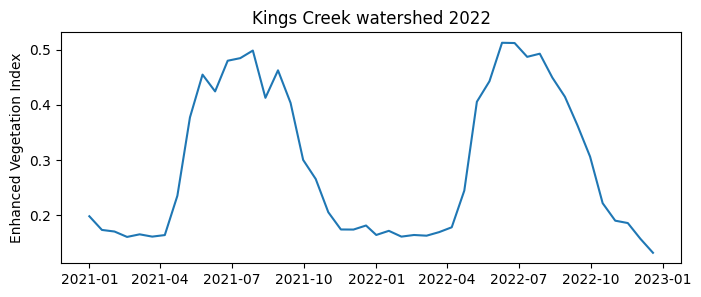

In [22]:
# Create figure
plt.figure(figsize=(8,3))
plt.title('Kings Creek watershed 2022')
plt.plot(df['date'], df['EVI_avg'])
plt.ylabel('Enhanced Vegetation Index')
plt.show()


## Example 2: Mean ground water anomaly for entire aquifer

The Gravity Recovery and Climate Experiment (GRACE) mission utilizes a pair of satellites in tandem orbit to measure small variations in Earth's gravitational pull. These variations are caused by changes in mass distribution, including water moving through the Earth's system. As water accumulates or depletes in an area, such as in an aquifer, it alters the region's gravitational attraction, which GRACE detects.

The application of GRACE data has been crucial in monitoring the Ogallala Aquifer, one of the largest aquifers in the world, stretching across eight states in the United States. Over-reliance on this aquifer for agricultural irrigation, municipal, and industrial water has led to substantial depletion in water levels. By capturing the changes in gravitational pull over the Ogallala region, GRACE has provided researchers and policymakers with essential data on the aquifer's depletion rates.

In [23]:
# Read boundary of Ogalla Aquifer
with open('../datasets/ogallala_aquifer_bnd.geojson') as file:
    roi_json = json.load(file)

# Define the ee.Geometry
roi = ee.Geometry(roi_json['features'][0]['geometry'])

# Create mask
mask = ee.Image.constant(1).clip(roi).mask()


In [24]:
# Get GRACE equivalent water thickeness anomaly 
grace = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
                  .filterDate('2002-04-01', '2017-01-07') \
                  .filterBounds(roi) \
                  .select('lwe_thickness_csr')


In [25]:
# Create function to apply the reduceRegion() method to each image
def compute_mean_water(image):
    mean_water = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=100_000,
        maxPixels=1e9
    )
    
    # Get the date of the image.
    date = image.date().format('YYYY-MM-dd')
    
    # Return a Feature with properties for mean water thickness and date.
    return ee.Feature(None, {'water_thickness_avg':mean_water.get('lwe_thickness_csr'),
                             'date': date})


In [ ]:
# Apply the created function to each image in the collection
# This operation results in a FeatureCollection
mean_water_thickness = grace.map(compute_mean_water)


In [26]:
# Convert the resulting Feature Collection to a list of dictionaries.
reducer = ee.Reducer.toList(2)
selector = ['date','water_thickness_avg']
data_list = mean_water_thickness.reduceColumns(reducer, selector).getInfo()


In [27]:
# Convert the list of data to a pandas DataFrame for easy handling and visualization.
df = pd.DataFrame(np.squeeze(data_list['list']), 
                  columns=['date','water_thickness_avg']).dropna()

# Convert dates to datetime format
df['date'] = pd.to_datetime(df['date'])

df['water_thickness_avg'] = df['water_thickness_avg'].astype(float)

# Display a few rows
df.head(3)


,date,water_thickness_avg
0,2002-04-01,7.638767
1,2002-05-01,7.061499
2,2002-08-01,-2.686608


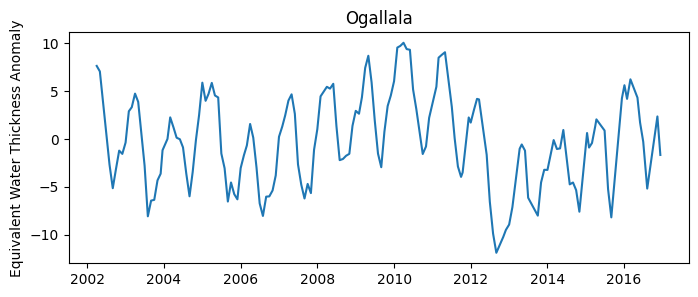

In [28]:
# Create figure
plt.figure(figsize=(8,3))
plt.title('Ogallala aquifer')
plt.plot(df['date'], df['water_thickness_avg'])
plt.ylabel('Equivalent Water Thickness Anomaly')
plt.show()